In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
df = pd.read_csv('prices-split-adjusted.csv')
pg = df[df['symbol'] == 'HAL']

In [3]:
pg.drop('open', axis = 1,  inplace=True)
pg.drop('low', axis = 1,  inplace=True)
pg.drop('high', axis = 1,  inplace=True)
pg.drop('symbol', axis = 1,  inplace=True)
pg.drop('volume', axis = 1,  inplace=True)

/Users/subhamgupta/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [4]:
def EMA(DF,a):
    df = DF.copy()
    df["EMA"]=df["close"].ewm(span=a,min_periods=a).mean() # ewm is Exponential Moving Average 
    df.dropna(inplace=True)
    return df

In [5]:
pg = EMA(pg, 8) 
# you can choose your own look back period, I've taken 8 here, generally we take 12 and 26 for MACD calculation  
pg

,date,close,EMA
3724,2010-01-13,34.049999,33.336927
4192,2010-01-14,34.310001,33.578308
4660,2010-01-15,34.029999,33.687532
5128,2010-01-19,34.599998,33.903938
5596,2010-01-20,33.270000,33.755803
...,...,...,...
848972,2016-12-23,54.840000,54.359605
849472,2016-12-27,54.910000,54.481915
849972,2016-12-28,54.299999,54.441489
850472,2016-12-29,54.040001,54.352270


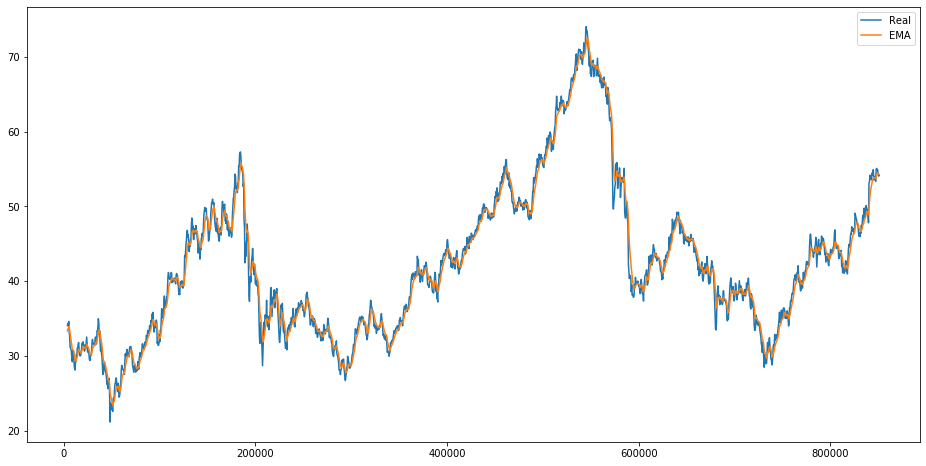

In [6]:
plt.figure(figsize=(16,8))
plt.plot(pg['close'])
plt.plot(pg['EMA'])
plt.legend(['Real', 'EMA'])

In [7]:
close = pg['close']
close = pd.DataFrame(data=close)

In [8]:
pg.drop('date', axis = 1,  inplace=True)
pg.drop('close', axis = 1,  inplace=True)

In [9]:
dataset = pg.values
train = dataset[0:1400,:]
valid = dataset[1400:,:]

In [10]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

In [11]:
x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [12]:
model = Sequential()
model.add(Dense(20,activation='tanh'))
model.add(Dense(10,activation='tanh'))
model.add(LSTM(units=50))
model.add(Dense(1))

In [13]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=64, batch_size=128, verbose=1)

Epoch 1/64
1340/1340 [==============================] - 7s 5ms/step - loss: 0.0639
Epoch 2/64
1340/1340 [==============================] - 3s 2ms/step - loss: 0.0120
Epoch 3/64
1340/1340 [==============================] - 3s 2ms/step - loss: 0.0064
Epoch 4/64
1340/1340 [==============================] - 3s 2ms/step - loss: 0.0028
Epoch 5/64
1340/1340 [==============================] - 3s 2ms/step - loss: 0.0014
Epoch 6/64
1340/1340 [==============================] - 3s 2ms/step - loss: 9.4237e-04
Epoch 7/64
1340/1340 [==============================] - 3s 2ms/step - loss: 8.7769e-04
Epoch 8/64
1340/1340 [==============================] - 3s 2ms/step - loss: 8.0706e-04
Epoch 9/64
1340/1340 [==============================] - 3s 2ms/step - loss: 7.6363e-04
Epoch 10/64
1340/1340 [==============================] - 3s 2ms/step - loss: 7.3756e-04
Epoch 11/64
1340/1340 [==============================] - 3s 2ms/step - loss: 7.1465e-04
Epoch 12/64
1340/1340 [==============================] - 3s 2

In [14]:
inputs = pg[len(pg) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)

In [15]:
X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

In [16]:
f = close[1400:].values

In [17]:
rms=np.sqrt(np.mean(np.power((f-closing_price),2))) # calculated w.r.t. original closing price, 'f' here
rms

1.5539223161197109

/Users/subhamgupta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


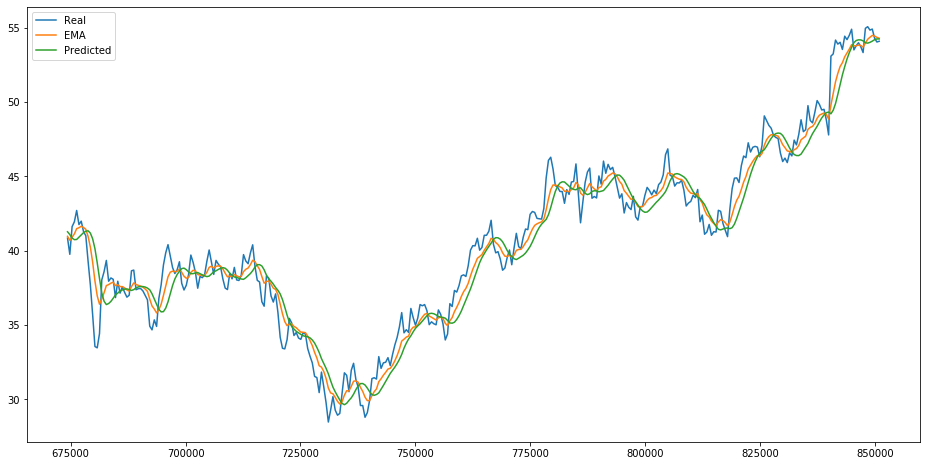

In [18]:
train = pg[:1400]
valid = pg[1400:]
valid['Predictions'] = closing_price
plt.figure(figsize=(16,8))
plt.plot(close['close'][1400:])
plt.plot(valid[['EMA','Predictions']])
plt.legend(['Real', 'EMA', 'Predicted'])

In [19]:
s = pg[len(pg) - 60:].values
s = s.reshape(-1,1)
s = scaler.transform(s)

In [20]:
s = np.reshape(s, (s.shape[1],s.shape[0],1))
closing_price = model.predict(s)
closing_price = scaler.inverse_transform(closing_price)
closing_price # next day closing price

array([[54.212597]], dtype=float32)